In [1]:
from inspect import signature
import time
import pprint
import pandas as pd
import requests
import sys
import json
import pymongo
from crossref.restful import Works
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
%matplotlib inline

In [2]:
# works = Works()

In [3]:
# help(works.query)

In [4]:
# for item in works.sample(1):
#     print(item.keys())

In [5]:
#query to be used
# "automated literature review"  OR  
# "automated literature search"  OR  
# "automated literature discovery"  AND  
# "NLP"  AND  
# "Machine Learning"

In [6]:
# works.query('Automatic Systematic Reviews using machine learning or natural language processing').count()

In [7]:
# query_string = 'Automated literature and systematic Reviews'

In [8]:
# w1 = works.query(bibliographic=query_string).select('DOI','title','is-referenced-by-count','score','subject')

In [9]:
# w1.count()

In [10]:
# li_all=[]
# start = time.time()
# for item in w1:
#     li_all.append(item.values())
# end = time.time()
# print(end-start)

In [11]:
#("automated literature review"  OR  "automated literature search"  OR  "automated literature discovery"  AND  "NLP"  AND  "Machine Learning")

In [12]:
# w1 = works.query(bibliographic='Systematic Literature Review', author='johannes', publisher_name='Wiley-Blackwell')

# for item in w1:
#     print(item['title'])

In [13]:
# download all the data related to query from crossref -- done
# then store it somewhere probably in mongodb
# remove duplicates
# 1 paper 1 row
# do clustering and find keywords for every cluster


In [14]:
# https://api.crossref.org/works?query.affiliation=Kalyani+University&filter=from-pub-date:2020-01-01,until-pub-date:2020-12-31,type:journal-article&select=DOI,title,container-title&rows=2&offset=0

In [15]:
# https://api.crossref.org/works?query.affiliation=Automated+literature+and+systematic+Reviews&filter=type:journal-article&select=DOI,title,container-title

In [16]:
# https://api.crossref.org/works?query.affiliation=Automated+literature+systematic+Reviews&filter=type:journal-article&select=DOI,publisher,title,is-referenced-by-count,score,subject,author,URL

In [17]:
# sys.getsizeof(response) #0.4 mb

In [18]:
# response = requests.get('https://api.crossref.org/works?query.title=Automated+literature+and+systematic+Reviews&filter=type:journal-article&select=DOI,title,score&rows=1000&cursor=*

In [19]:
#starts from here........

In [2]:
def get_latest_date():
    
    response = requests.get('https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article&select=DOI,title,score,created,abstract&sort=created&order=desc&rows=1&cursor=*').text
    response_info = json.loads(response)
    latest_date = response_info['message']['items'][0]['created']['date-parts'][0]
    return latest_date
    

In [3]:
def get_oldest_date():
    
    response = requests.get('https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article&select=DOI,title,score,created,abstract&sort=created&order=asc&rows=1&cursor=*').text
    response_info = json.loads(response)
    oldest_date = response_info['message']['items'][0]['created']['date-parts'][0]
    return oldest_date



In [4]:
latest_date = get_latest_date()
latest_date

[2022, 11, 29]

In [5]:
oldest_date = get_oldest_date()
oldest_date

[2002, 7, 25]

In [6]:
base_oldest = datetime.date(oldest_date[0],oldest_date[1],oldest_date[2])
base_latest = datetime.date(latest_date[0],latest_date[1],latest_date[2])
numweeks = 2
upd_date = base_oldest
date_list=[]
while upd_date <= base_latest:
    date_list.append(upd_date)
    upd_date = upd_date + datetime.timedelta(weeks=numweeks)
    
    date_list.append(upd_date)

In [7]:
def init_url(date_list):
    url = 'https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:'
    url = url+str(date_list[0])+',until-created-date:'+str(date_list[1])+'&select=DOI,title,score,created,abstract&rows=1000&cursor=*'
    return url

In [8]:
def cursor_url(date_list, cursor):
    url = 'https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:'
    url = url+str(date_list[0])+',until-created-date:'+str(date_list[1])+'&select=DOI,title,score,created,abstract&rows=1000&cursor='
    url = url + str(cursor)
    return url
    

In [9]:
db_name = "thesis"
test_client = pymongo.MongoClient('mongodb://localhost:27017/')
test_db = test_client[db_name]


def check_for_db(test_client,db_name):
    dblist = test_client.list_database_names()
    if db_name in dblist:
        print(db_name + ' ← database exists')
    else:
        print(db_name + ' ← database does NOT exists')
check_for_db(test_client,db_name) # check if database exists or not


# make collection
col_name='query_results_full_load'
test_col = test_db[col_name]

thesis ← database exists


In [10]:
date_list = list(set(date_list))

In [11]:
date_list.sort()

In [30]:
#date_list = date_list[0:3]

In [ ]:
start = time.time()
cursors_li=[]
missed_records = []

for seg in range(len(date_list)):
    
    if len(date_list) == seg+1:
        break
    else:  
        url = init_url(date_list[seg:seg+2])
        response = requests.get(url).text
        response_info = json.loads(response)
        
        if len(response_info['message']['items']) !=0:
            pl = test_col.insert_many(response_info['message']['items'])
            a = response_info['message']['next-cursor']
            cursors_li.append(a)
            url = cursor_url(date_list[seg:seg+2], a)
            print(url,"\n\n*************")
            ct = 0
            while len(response_info['message']['items']) != 0:
                try:
                    response = requests.get(url).text
                    response_info = json.loads(response)
                    pl = test_col.insert_many(response_info['message']['items'])
                    #a = response_info['message']['next-cursor']
                    #url = cursor_url(date_list[seg:seg+2], a)
                except:
                    #if there is no response from the api for a url, which means either it timed out
                    #or exhausted, in that case the message will be
                    #empty and there will be nothing to enter in the database
                    #this exception handler will handle such cases
                    ct +=1
                    if ct==1:
                        print("All Extracted:moving on to next segment")
                    else:
                        #save the url
                        missed_records.append(url)
                        print("API timed out:skipping and moving on to next segment")
                        #get out of the while loop and fetch records for the next segment
                        break
        else:
            continue

        
end = time.time()
print(end-start)

#need to add a condition which checks if the while is stuck for one request for a long time

https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2002-07-25,until-created-date:2002-08-08&select=DOI,title,score,created,abstract&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASOFUfFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAFxYWxhZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAABcWFscWR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASt3oeFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEAWGRhZfNEZlTDBRZ1FuLWZ4NVhlZU9MYzN3AAAAABCKmf0WaDRJMjhrcXVUOGE3dDI1VDhnWHMyZw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2002-08-22,until-created-date:2002-09-05&select=DOI,title,score,created,abstract&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASOFc_FkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD42OvxY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAABcWGi4WR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASt3y-Fk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEjfBvRZDNTBUdXhPeVM0bUg3UnZzc

All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2003-03-06,until-created-date:2003-03-20&select=DOI,title,score,created,abstract&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASOFsIFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD42SIRY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAAADlXr4WMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAASt4ECFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEjfF6BZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABCKnyUWaDRJMjhrcXVUOGE3dDI1VDhnWHMyZw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2003-03-20,until-created-date:2003-04-03&select=DOI,title,score,created,abstract&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASOFuJFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAFxYgkxZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAABcWIJQWR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASt4GzFk5qWk1fWm1iUVV1V3Nwd3MxN

All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2003-10-02,until-created-date:2003-10-16&select=DOI,title,score,created,abstract&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASOF8qFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD42WLhY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAAADlZWoWMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAASt4brFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEjfLjhZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABCGRO0WSTFVWlpBeGRTWi1nRllxOU9nQUYydw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2003-10-16,until-created-date:2003-10-30&select=DOI,title,score,created,abstract&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAA5WYiFjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAFxYnOhZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAABcWJzsWR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASt4d7Fk5qWk1fWm1iUVV1V3Nwd3MxN

All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2004-04-29,until-created-date:2004-05-13&select=DOI,title,score,created,abstract&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAAA5WryFjFGV1lXWE94VGU2bUMzaVRjNzc2aFEAAAAAFxYsSRZHblpDbkEzT1FvRy0tOGFOZ05EOHVnAAAAAADlavMWMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAAR7rMjFjdhbGlIQ0JtVEVlMW9yN2RJbTBZV2cAAAAAEAWTCRZfNEZlTDBRZ1FuLWZ4NVhlZU9MYzN3AAAAABCGSEkWSTFVWlpBeGRTWi1nRllxOU9nQUYydw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2004-05-13,until-created-date:2004-05-27&select=DOI,title,score,created,abstract&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASOGOEFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD42aGBY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAAADla50WMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAASt4vLFk5qWk1fWm1iUVV1V3Nwd3MxN

All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2004-11-25,until-created-date:2004-12-09&select=DOI,title,score,created,abstract&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASOWSIFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD46cJhY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAAADnEkYWMUZXWVdYT3hUZTZtQzNpVGM3NzZoUQAAAAASuMoIFk5qWk1fWm1iUVV1V3Nwd3MxN3FqQ3cAAAAAEjkE_BZDNTBUdXhPeVM0bUg3UnZzcl9lR2N3AAAAABCHVG4WSTFVWlpBeGRTWi1nRllxOU9nQUYydw== 

*************
All Extracted:moving on to next segment
https://api.crossref.org/works?query=Automated+literature+and+systematic+Reviews&filter=type:journal-article,from-created-date:2004-12-09,until-created-date:2004-12-23&select=DOI,title,score,created,abstract&rows=1000&cursor=DnF1ZXJ5VGhlbkZldGNoBgAAAAASOWTmFkhUQjJYNFlSVFVPT1k5bVZmVDQzQXcAAAAAD46cixY0amo4YndCWVRadUx4QV9WQlVKWHdnAAAAABcXxo0WR25aQ25BM09Rb0ctLThhTmdORDh1ZwAAAAASuMqTFk5qWk1fWm1iUVV1V3Nwd3MxN

In [32]:
# test_dict = { "surname": "Adamyan", "address": "Meliq Adamyan 1",
#              "city": "Yerevan" }
# pl = test_col.insert_one(test_dict)

In [33]:
db_name = "thesis"
test_client = pymongo.MongoClient('mongodb://localhost:27017/')
test_db = test_client[db_name]


def check_for_db(test_client,db_name):
    dblist = test_client.list_database_names()
    if db_name in dblist:
        print(db_name + ' ← database exists')
    else:
        print(db_name + ' ← database does NOT exists')
check_for_db(test_client,db_name) # check if database exists or not

thesis ← database exists


In [34]:
col_name='query_results_full_load'
test_col = test_db[col_name]

In [35]:
x = test_col.find()

In [36]:
li_all=[]
for data in x:
    li_all.append(data)

In [37]:
len(li_all)

67706

In [38]:
li_all[1:3]

[{'_id': ObjectId('6386273cf28ca9b4aebb11ed'),
  'DOI': '10.1080/146392400445891',
  'title': ['Software reviews'],
  'score': 15.07332,
  'created': {'date-parts': [[2002, 7, 26]],
   'date-time': '2002-07-26T12:14:43Z',
   'timestamp': 1027685683000}},
 {'_id': ObjectId('6386273cf28ca9b4aebb11ee'),
  'DOI': '10.1046/j.1365-3113.2002.00180.x',
  'title': ['Book Reviews'],
  'score': 15.033997,
  'created': {'date-parts': [[2002, 7, 28]],
   'date-time': '2002-07-28T21:46:32Z',
   'timestamp': 1027892792000}}]

In [144]:
df_all = pd.DataFrame(li_all)

In [145]:
#drop duplicates is present
df_all.drop_duplicates(subset=['DOI'],inplace=True)

In [105]:
df_all.shape

(34853, 6)

In [106]:
df_all.head()

,_id,DOI,title,score,created,abstract
0,6386273cf28ca9b4aebb11ec,10.1136/bmj.323.7312.546,[Assessment of therapeutic safety in systemati...,17.001375,"{'date-parts': [[2002, 7, 27]], 'date-time': '...",NaN
1,6386273cf28ca9b4aebb11ed,10.1080/146392400445891,[Software reviews],15.073320,"{'date-parts': [[2002, 7, 26]], 'date-time': '...",NaN
2,6386273cf28ca9b4aebb11ee,10.1046/j.1365-3113.2002.00180.x,[Book Reviews],15.033997,"{'date-parts': [[2002, 7, 28]], 'date-time': '...",NaN
3,6386273cf28ca9b4aebb11ef,10.1136/bmj.323.7306.224,[Systematic reviews in health care: Systematic...,14.969360,"{'date-parts': [[2002, 7, 27]], 'date-time': '...",NaN
4,6386273cf28ca9b4aebb11f0,10.1046/j.1365-3113.1999.00077.x,[Book Reviews],14.920623,"{'date-parts': [[2002, 7, 26]], 'date-time': '...",NaN


In [107]:
df_all.isna().sum() #no na values

_id             0
DOI             0
title          13
score           0
created         0
abstract    33536
dtype: int64

In [146]:
df_all.dropna(subset=['title','abstract'],inplace=True)

In [109]:
df_all.shape

(1317, 6)

In [147]:
df_all.reset_index(inplace=True)

In [111]:
df_all.loc[0,'abstract']

'<jats:p>Chronic obstructive pulmonary disease (COPD) is the fifth leading\n   cause of mortality in the USA. For 1984 to 1993, among\n   Canadian seniors aged over 65, COPD was the fourth cause of mortality\n   in men and the seventh in women. Though the underlying\n   pathology is initially confined to the lungs, the associated physical\n   deconditioning and the emotional responses to chronic respiratory\n   disease contribute greatly to the resulting morbidity. Increased\n   shortness of breath leads to inactivity and consequent\n   cardiorespiratory and muscular deconditioning, which in turn leads to\n   further inactivity, social isolation, fear of dyspnoea and\n   depression. Respiratory rehabilitation may offer a way to break this vicious circle.</jats:p>'

In [113]:
text = " ".join(tl for tl in df_all.abstract)
text_t = " ".join(tl[0] for tl in df_all.title) #for title

In [115]:
text[0:2000]

'<jats:p>Chronic obstructive pulmonary disease (COPD) is the fifth leading\n   cause of mortality in the USA. For 1984 to 1993, among\n   Canadian seniors aged over 65, COPD was the fourth cause of mortality\n   in men and the seventh in women. Though the underlying\n   pathology is initially confined to the lungs, the associated physical\n   deconditioning and the emotional responses to chronic respiratory\n   disease contribute greatly to the resulting morbidity. Increased\n   shortness of breath leads to inactivity and consequent\n   cardiorespiratory and muscular deconditioning, which in turn leads to\n   further inactivity, social isolation, fear of dyspnoea and\n   depression. Respiratory rehabilitation may offer a way to break this vicious circle.</jats:p> <jats:p>Smokebusters is a community‐based smoking prevention initiative for young people which aims to prevent them from starting to smoke. Although the number of clubs throughout the UK and Europe has increased over the last 

In [119]:
CLEANR = re.compile('<.*?>') 

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

cleaned_text = cleanhtml(text)

#cleaned_text = re.sub('\W+',' ',text)
cleaned_text = re.sub('[^A-Za-z0-9]+',' ',text)

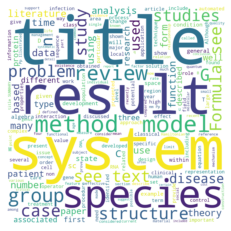

In [123]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["p","jats","italic","bold","abstract","sup","sub","sup","two","s","sec","h","e","one","new","may"])

# Generate a word cloud image
wordcloud = WordCloud(width = 1000, height = 1000,stopwords=stopwords, background_color="white").generate(cleaned_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [148]:
def preprocess_text(df):
    
    CLEANR = re.compile('<.*?>') 

    def cleanhtml(raw_html):
      cleantext = re.sub(CLEANR, '', raw_html)
      return cleantext

    df = df.map(lambda x: cleanhtml(x))

    df = df.map(lambda x: re.sub('[^A-Za-z0-9]+',' ',x))

    df = df.map(lambda x: x.lower(  ))

    df = df.map(lambda x: remove_stopwords(x))

    df = df.map(lambda x: x.split())
    
    return df

In [149]:
#converted the title type from list to string
df_all['title'] =  df_all['title'].map(lambda x: x[0])
df_all['title'] = preprocess_text(df_all['title'])

In [151]:
df_all['abstract'] = preprocess_text(df_all['abstract'])

In [152]:
df_all.head()

,index,_id,DOI,title,score,created,abstract
0,6,6386273cf28ca9b4aebb11f2,10.1017/s0959259897007466,"[respiratory, rehabilitation, chronic, obstruc...",14.500789,"{'date-parts': [[2002, 7, 27]], 'date-time': '...","[chronic, obstructive, pulmonary, disease, cop..."
1,64,6386273cf28ca9b4aebb122c,10.1108/09654289910256941,"[systematic, reviews, health, promotion, initi...",11.425545,"{'date-parts': [[2002, 7, 28]], 'date-time': '...","[smokebusters, community, based, smoking, prev..."
2,80,6386273cf28ca9b4aebb123c,10.1017/s0033291796004291,"[editorial, systematic, reviews, meta, analysis]",11.167559,"{'date-parts': [[2002, 7, 27]], 'date-time': '...","[conclusions, medical, interventions, causes, ..."
3,99,6386273cf28ca9b4aebb124f,10.1191/0269215502cr469oa,"[systematic, reviews, rehabilitation, stroke, ...",10.602030,"{'date-parts': [[2002, 7, 27]], 'date-time': '...","[objectives, problems, encountered, undertakin..."
4,116,6386273cf28ca9b4aebb1260,10.1161/hs0202.102880,"[costs, benefits, carotid, endarterectomy, ass...",10.192738,"{'date-parts': [[2002, 7, 28]], 'date-time': '...","[background, purpose, carotid, endarterectomy,..."


In [158]:
tokenize = df_all['abstract']

In [153]:

# df_all['abstract']= df_all['abstract'].map(lambda x: remove_stopwords(x))
# #n-gram transformation, tokenizing


# tokenize = df_all['abstract'].map(lambda x: x.split())

# df_all.head()

In [159]:
#train W2V model, generate W2V embeddings
# define training data
sentences = tokenize
# train model
model = Word2Vec(sentences, min_count=1)

In [160]:
# summarize the loaded model
print(model)

Word2Vec<vocab=18166, vector_size=100, alpha=0.025>


In [161]:
# summarize vocabulary
words = list(model.wv.key_to_index)
print(words[0:10])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

['1', 's', '2', 'new', 'species', '3', 'theory', 'quantum', 'studies', 'formula']
Word2Vec<vocab=18166, vector_size=100, alpha=0.025>


In [162]:
#calculate similarity, reduce dimensions, plot graph
model.wv.most_similar('literature')

[('data', 0.9998142719268799),
 ('analysis', 0.9998125433921814),
 ('disease', 0.9998041391372681),
 ('results', 0.9997997283935547),
 ('information', 0.9997977614402771),
 ('years', 0.9997963309288025),
 ('developed', 0.9997959733009338),
 ('studies', 0.9997848272323608),
 ('systems', 0.9997822046279907),
 ('different', 0.9997801780700684)]

In [59]:
# print(pl.inserted_id)


In [60]:
# test_df = pd.DataFrame(li,columns=['objId','DOI','title','score'])

In [61]:
#response_info['message']['items']

In [62]:
## insert many players
# db_name='players'
# col_name='coach'
# test_client = pymongo.MongoClient("mongodb://localhost:27017/")
# test_db = test_client[db_name]
# test_col = test_db[col_name]
# test_list=[{ "surname": "player1", "address": "Meliq Adamyan 1",
#             "city": "Yerevan1" },
#            { "surname": "player2", "address": "Meliq Adamyan 2",
#             "city": "Yerevan2" },
#            { "surname": "player3", "address": "Meliq Adamyan 3",
#             "city": "Yerevan3" },
#            { "surname": "player4", "address": "Meliq Adamyan 4",
#             "city": "Yerevan4" }
#            ]

#print list of the _id values of the inserted players:
